In [29]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt 
import gc
from IPython.display import clear_output

In [30]:
from decoder import Decoder
from discriminator import Discriminator
from encoder import Encoder

In [31]:
PATH="C:\\Users\\vicin\Desktop\\PoliTo\\ML_for_CV\\CGAN"


In [32]:
class CustomDataset(Dataset):
    def __init__(self, img_dir,transforms=None, target_transforms=None):
        self.img_dir=img_dir
        self.transforms=transforms
        self.target_transforms=target_transforms
        self.imgs=[]
        self.imgs.extend([self.img_dir+'\\'+i for i in os.listdir(self.img_dir) if i.endswith('.jpg')])
        print(self.imgs)

    def __getitem__(self, index):
        img=read_image(self.imgs[index]).float()
        img/=255

        col,seg=img.split([256,256], 2)
        return col,seg
    
    def __len__(self):
        return len(self.imgs)
    
dataset_train=CustomDataset(PATH+'\\cityscapes\\cityscapes_data\\train')
#dataset_train=dataset_train[100][:]
dataset_train,_=random_split(dataset_train,[500,len(dataset_train)-500])
dataset_val=CustomDataset(PATH+'\\cityscapes\\cityscapes_data\\val')

dataloader_train=DataLoader(dataset_train,16, shuffle=True)
dataloader_val=DataLoader(dataset_val,16, shuffle=True)

['C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\10.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\100.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1000.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1001.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1002.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1003.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1004.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1005.jpg', 'C:\\Users\\vicin\\Desktop\\PoliTo\\ML_for_CV\\CGAN\\cityscapes\\cityscapes_data\\train\\1006.jpg', 'C:\\

In [33]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [34]:
### TEST DECODER ###
r=torch.randn(16,100,2,2).cuda()

print(r.shape)

encoder=Encoder().cuda()
decoder=Decoder().cuda()
discriminator=Discriminator().cuda()

encoder.apply(weights_init)
decoder.apply(weights_init)
discriminator.apply(weights_init)

# print(discriminator(decoder(r)).shape)
# print(encoder(decoder(r)).shape)
# print(decoder(r).shape)



torch.Size([16, 100, 2, 2])


Discriminator(
  (seq): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


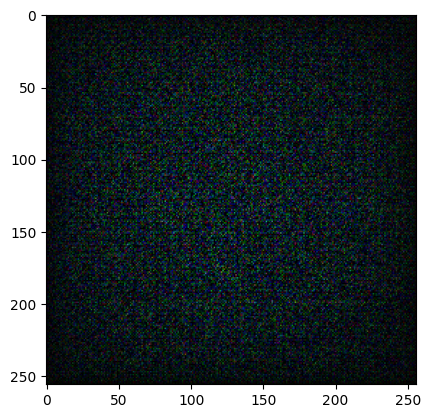

In [35]:
plt.imshow(decoder(r)[0].cpu().detach().permute([1,2,0]))

In [36]:
optimizerDisc=optim.Adam(discriminator.parameters(), 0.0002, (0.5,0.9))
optimizerDec=optim.Adam(decoder.parameters(), 0.0002, (0.5,0.9))

enc_dec_param=list(decoder.parameters())+list(encoder.parameters())
optimizerEncDec=optim.Adam(enc_dec_param, 0.0002, (0.5,0.999))

criterion=nn.BCELoss()
criterion_encoder=nn.SmoothL1Loss()

In [37]:
### Train-Loop GAN ###
def optimize_GAN():
    global decoder, discriminator, dataloader_train
    accuracy=0
    for (data,seg) in dataloader_train:
        batch_size=data.shape[0]
        data_gpu=data.cuda()
        seg_gpu=seg.cuda()

        latent_batch=encoder(seg_gpu)

        fake_data=decoder(latent_batch)

        ### Train Discriminator ### 
        discriminator.zero_grad()
        decoder.zero_grad()
        
        label1=torch.full((batch_size,), 1.).cuda() #Etichetta immagini reali
        output1=discriminator(data_gpu).view(-1) # predizioni
        errDisc_real=criterion(output1, label1) # cross entropy

        accuracy+=output1.eq(1.).sum().item()

        label2=torch.full((batch_size,), 0.).cuda()
        output2=discriminator(fake_data.detach()).view(-1)
        errDisc_fake=criterion(output2,label2)

        accuracy+=output1.eq(0.).sum().item()

        
        errDisc=errDisc_real+errDisc_fake
        errDisc.backward()
        optimizerDisc.step()
        
        ### Train Decoder ###
        
        output3=discriminator(fake_data).view(-1)
        errDec=criterion(output3, label1)

        errDec.backward()
        optimizerDec.step()
    return accuracy/len(dataloader_train.dataset), fake_data[0]

In [38]:
def optimize_encoder_decoder():
    global encoder, decoder, discriminator, dataloader_train
    accuracy=0
    for (data,seg) in dataloader_train:
        batch_size=data.shape[0]
        data_gpu=data.cuda()
        seg_gpu=seg.cuda()

        latent_batch=encoder(seg_gpu)

        fake_data=decoder(latent_batch)

        ### Train Discriminator ### 
        discriminator.zero_grad()
        decoder.zero_grad()
        encoder.zero_grad()
        

        label1=torch.full((batch_size,), 1.).cuda() #Etichetta immagini reali
        output1=discriminator(torch.cat([data_gpu,seg_gpu], dim=1)).view(-1) # predizioni
        errDisc_real=criterion(output1, label1) # cross entropy

        accuracy+=output1.eq(1.).sum().item()

        label2=torch.full((batch_size,), 0.).cuda()
        output2=discriminator(torch.cat([fake_data.detach(),seg_gpu], dim=1)).view(-1)
        errDisc_fake=criterion(output2,label2)

        accuracy+=output1.eq(0.).sum().item()

        
        errDisc=errDisc_real+errDisc_fake
        errDisc.backward()
        optimizerDisc.step()
        
        ### Train Decoder ###
        
        
        # errDec=criterion_encoder(fake_data, data_gpu)

        # errDec.backward()
        # optimizerEncDec.step()

        output3=discriminator(torch.cat([fake_data, seg_gpu], dim=1)).view(-1)
        errGen=criterion(output3, label1)
        errGen.backward()
        optimizerEncDec.step()
        fake_data.cpu()
        data_gpu.cpu()
        seg_gpu.cpu()
        gc.collect()
        torch.cuda.empty_cache()
        
    return accuracy/len(dataloader_train.dataset), fake_data[0], seg[0]

In [39]:

### Train Loop ###
epochs=500
start_epoch=0
if "neverStreets" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets")
    if state:
      discriminator.load_state_dict(state["Discriminator"])
      decoder.load_state_dict(state["Decoder"])
      encoder.load_state_dict(state["Encoder"])
      optimizerDisc.load_state_dict(state["optimizerD_state_dict"])
      optimizerEncDec.load_state_dict(state["optimizerED_state_dict"])
      start_epoch=state["epoch"]
  except:
    print("Error in load")



for i in range(start_epoch, epochs):
    print("Epoch ",i)
    accuracy, fake_data, seg=optimize_encoder_decoder()
    
    clear_output(wait=True)
    print("Saving...")
    torch.save({"Discriminator":discriminator.state_dict(),
    "optimizerD_state_dict":optimizerDisc.state_dict(),
    "Decoder":decoder.state_dict(),
    "Encoder":encoder.state_dict(),
    "optimizerED_state_dict":optimizerEncDec.state_dict(),
    "epoch":i},
    "./neverStreets")
    print(accuracy)
    
    plt.subplot(121)
    plt.imshow(fake_data.cpu().detach().permute([1,2,0]))
    plt.subplot(122)
    plt.imshow(seg.cpu().detach().permute([1,2,0]))
    plt.show()

Epoch  0


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.01 GiB is allocated by PyTorch, and 1.31 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Loading...


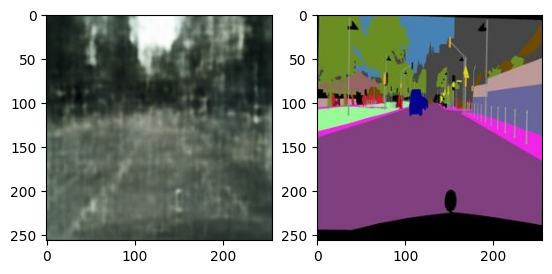

In [ ]:
import random
decoder=Decoder().cuda()
encoder=Encoder().cuda()

if "neverStreets" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets")
    if state:
      encoder.load_state_dict(state["Encoder"])
      #disc.load_state_dict(state["Discriminator"])
      decoder.load_state_dict(state["Decoder"])
      #optimizerDisc.load_state_dict(state["optimizerD_state_dict"])
      #optimizerDec.load_state_dict(state["optimizerG_state_dict"])
      #start_epoch=state["epoch"]
  except:
    print("Error in load")


data,seg=next(iter(dataloader_val))
#fake_data=decoder(torch.randn([16,100,1,1], device='cuda'))
r=random.randint(0, len(data)-1)
fake_data=decoder(encoder(seg.cuda()))
to_image=transforms.ToPILImage()
plt.subplot(121)
plt.imshow(to_image(fake_data[r].clip(0,1).cpu()))
plt.subplot(122)
plt.imshow(to_image(seg[r].clip(0,1).cpu()))